In [1]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('groups1.xlsx', sheet_name='ttps')
df = df.drop(columns=['source name', 'source ref', 'source type', 'mapping type', 'target name', 'target ref', 'target type', 'mapping description', 'STIX ID'])

df.head()

,sourceID,targetID,created,last modified
0,G0099,T1105,07 May 2020,14 October 2020
1,G0099,T1204.002,05 May 2020,14 October 2020
2,G0099,T1036.004,07 May 2020,14 October 2020
3,G0099,T1571,05 May 2020,14 October 2020
4,G0099,T1027,05 May 2020,14 October 2020


In [3]:
# Create a default dictionary to hold the desired structure
grouped_data = defaultdict(dict)

# Iterate through each row to populate the dictionary
for index, row in df.iterrows():
    # Using targetID as key and a tuple (created, last_modified) as value for each sourceID
    grouped_data[row['sourceID']][row['targetID']] = [row['created'][-4:], row['last modified'][-4:]]

# Convert the default dictionary to a regular dictionary if needed
grouped_data = dict(grouped_data)

# To create a DataFrame from this structure
# First, we prepare a list of tuples representing each row
rows_list = [(sourceID, targets) for sourceID, targets in grouped_data.items()]
# Create a new DataFrame
new_df = pd.DataFrame(rows_list, columns=['sourceID', 'Targets'])

print(new_df)

    sourceID                                            Targets
0      G0099  {'T1105': ['2020', '2020'], 'T1204.002': ['202...
1      G0006  {'T1560.001': ['2017', '2020'], 'T1119': ['201...
2      G0005  {'T1102.002': ['2019', '2020'], 'T1568.003': [...
3      G0023                    {'T1584.004': ['2020', '2022']}
4      G0025  {'T1585': ['2020', '2020'], 'T1583.006': ['202...
..       ...                                                ...
133    G0044  {'T1553.002': ['2017', '2019'], 'T1583.001': [...
134    G0102  {'T1560.001': ['2023', '2023'], 'T1197': ['202...
135    G0128  {'T1102.002': ['2021', '2021'], 'T1555.003': [...
136    G0018  {'T1203': ['2019', '2019'], 'T1083': ['2017', ...
137    G0045  {'T1560': ['2019', '2020'], 'T1560.001': ['201...

[138 rows x 2 columns]


1. Trend Analysis: 
Identify how the activity of different threat actors has evolved over time. This can involve counting the number of new techniques adopted by each actor over time or the changes in their techniques.

In [4]:
# Extract years when each technique was adopted
def extract_years(target_dict):
    return {target: dates[0] for target, dates in target_dict.items()}

new_df['Start_Years'] = new_df['Targets'].apply(extract_years)

# Flatten the DataFrame to have one row per sourceID and target
rows = []
for _, row in new_df.iterrows():
    for target, year in row['Start_Years'].items():
        rows.append({'sourceID': row['sourceID'], 'Target': target, 'Year': year})

flat_df = pd.DataFrame(rows)

# Count the number of new techniques per year for each sourceID
trend_analysis = flat_df.groupby(['sourceID', 'Year']).size().reset_index(name='New Techniques')

print(trend_analysis.sort_values(by='New Techniques', ascending=False))


    sourceID  Year  New Techniques
89     G0034  2020              57
94     G0035  2021              54
332    G1016  2023              53
263    G0102  2020              45
323    G1006  2022              44
..       ...   ...             ...
260    G0099  2021               1
162    G0060  2021               1
164    G0061  2020               1
257    G0098  2021               1
168    G0063  2018               1

[336 rows x 3 columns]


2. Time Series Analysis: 
For each threat actor or technique, analyze the frequency of occurrence over time to identify any seasonal patterns or trends.

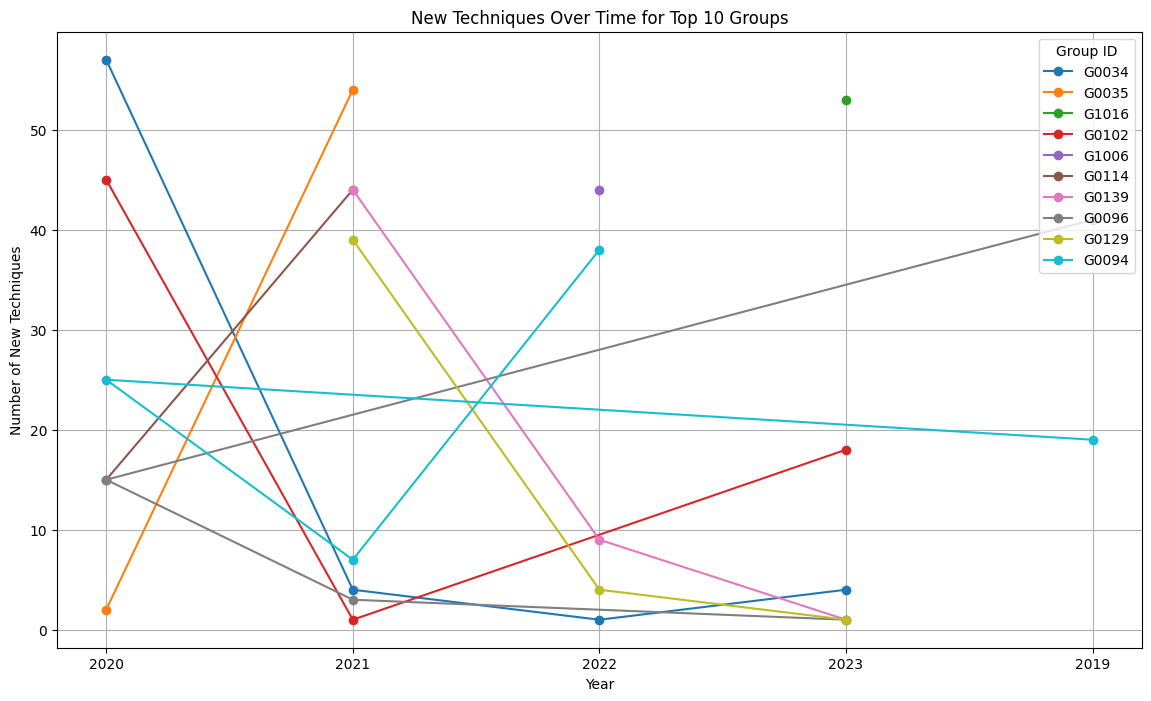

In [5]:
top_10_groups = trend_analysis.sort_values(by='New Techniques', ascending=False).head(10)
plt.figure(figsize=(14, 8))

# Iterate through the top 10 groups
for sourceID in top_10_groups['sourceID']:
    group_data = trend_analysis[trend_analysis['sourceID'] == sourceID]
    
    # Plot each group's data
    plt.plot(group_data['Year'], group_data['New Techniques'], marker='o', label=sourceID)

plt.title("New Techniques Over Time for Top 10 Groups")
plt.xlabel('Year')
plt.ylabel('Number of New Techniques')
plt.grid(True)
plt.legend(title="Group ID")
plt.show()

3. Survival Analysis: 
Assess the "lifetime" of specific techniques within groups to see how long they stay relevant or are actively used before being modified or dropped.

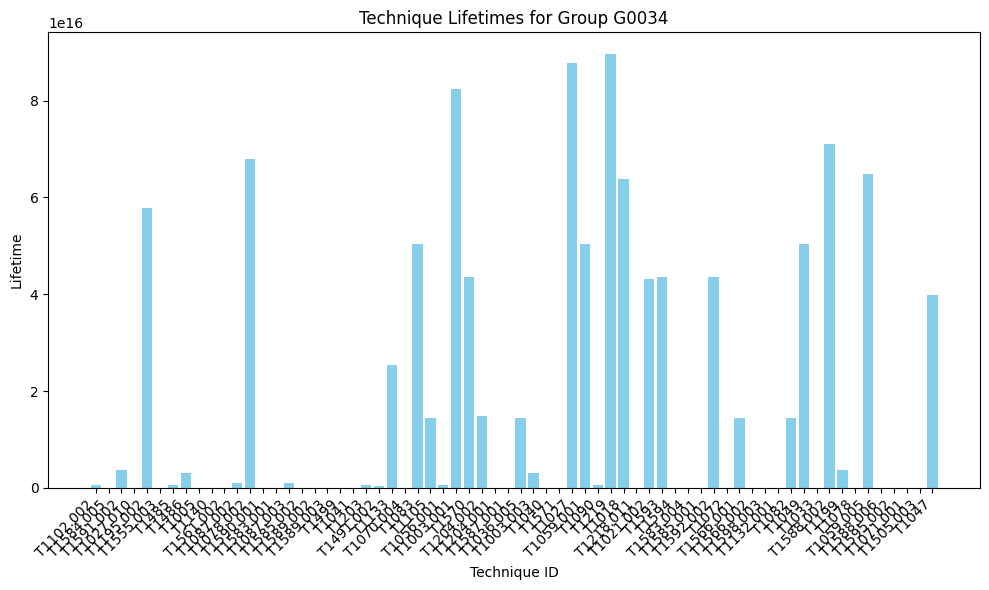

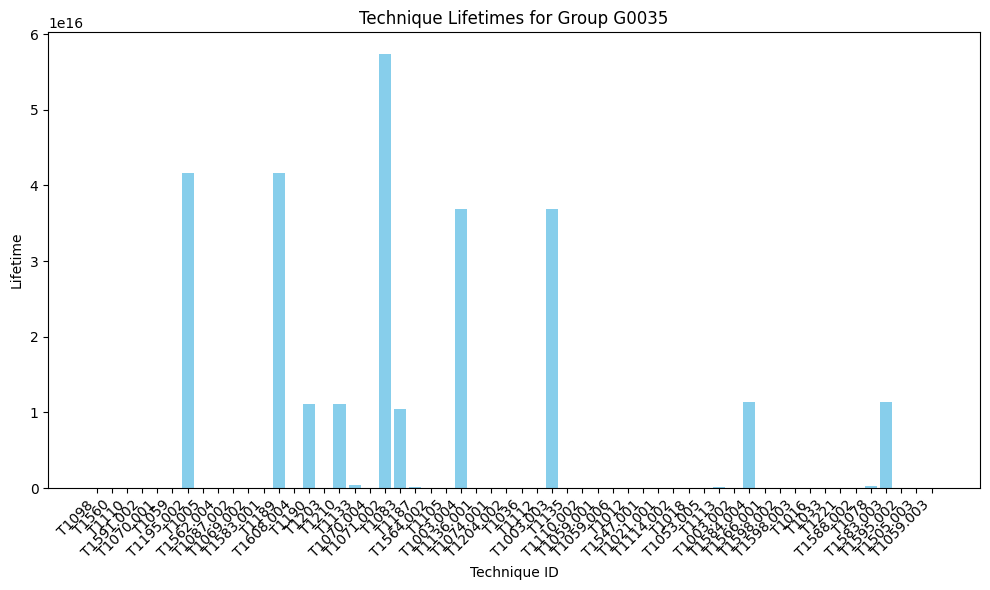

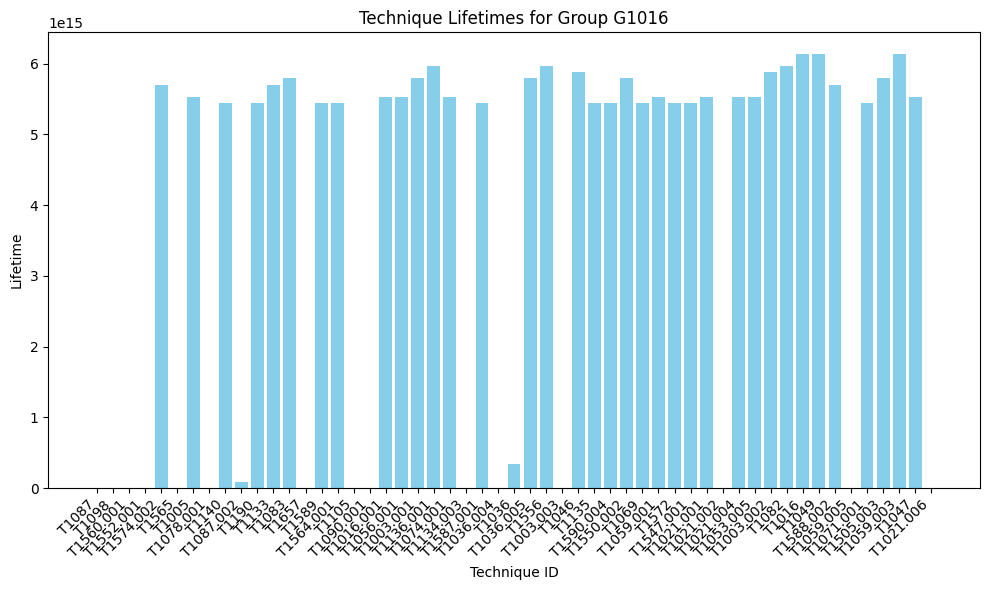

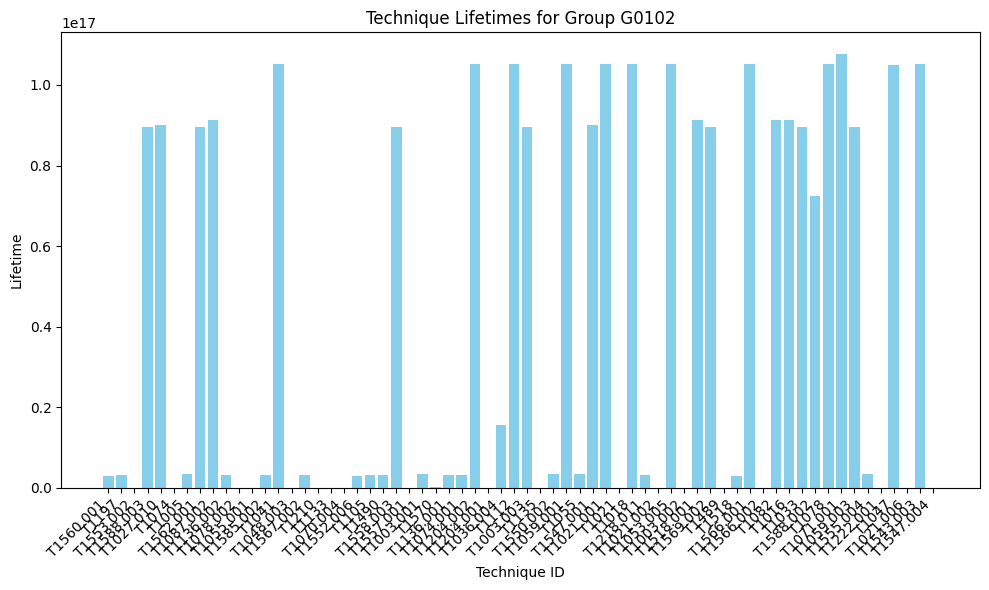

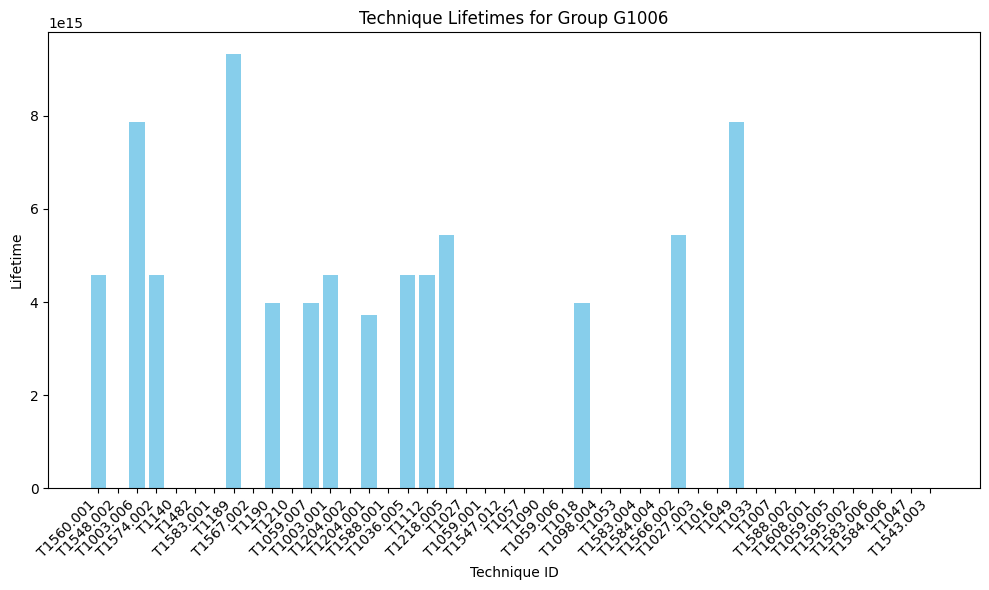

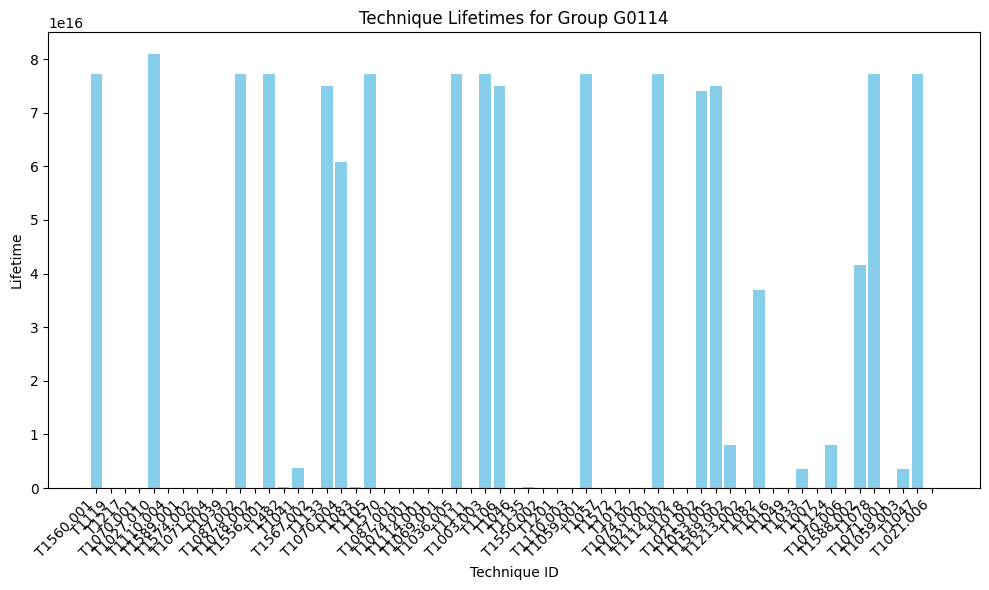

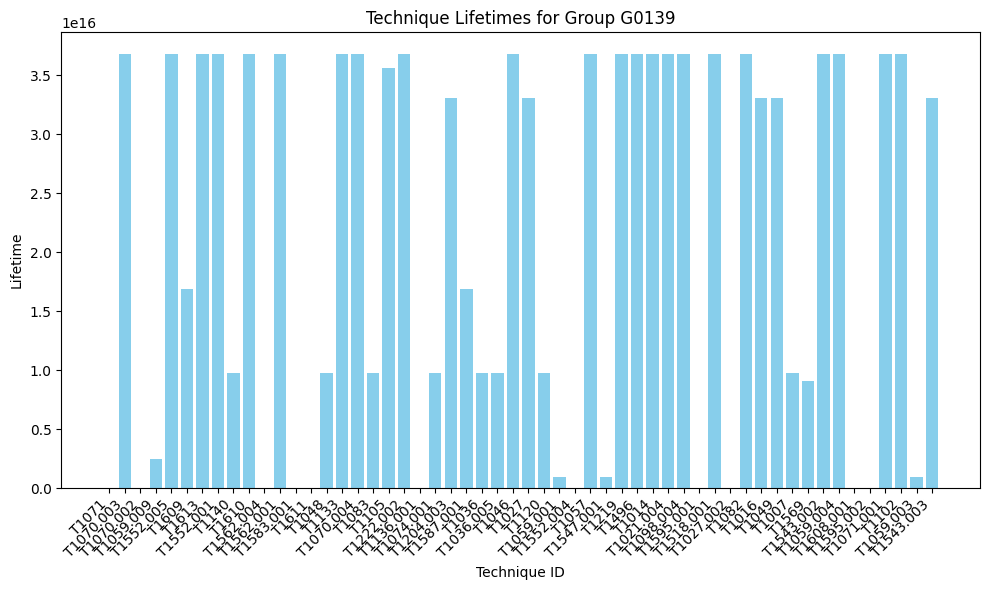

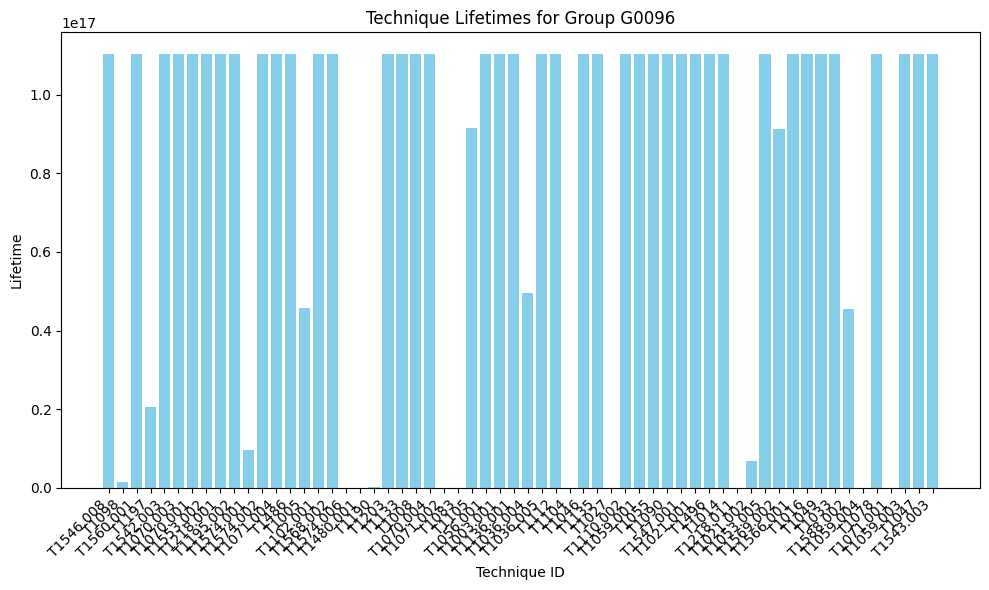

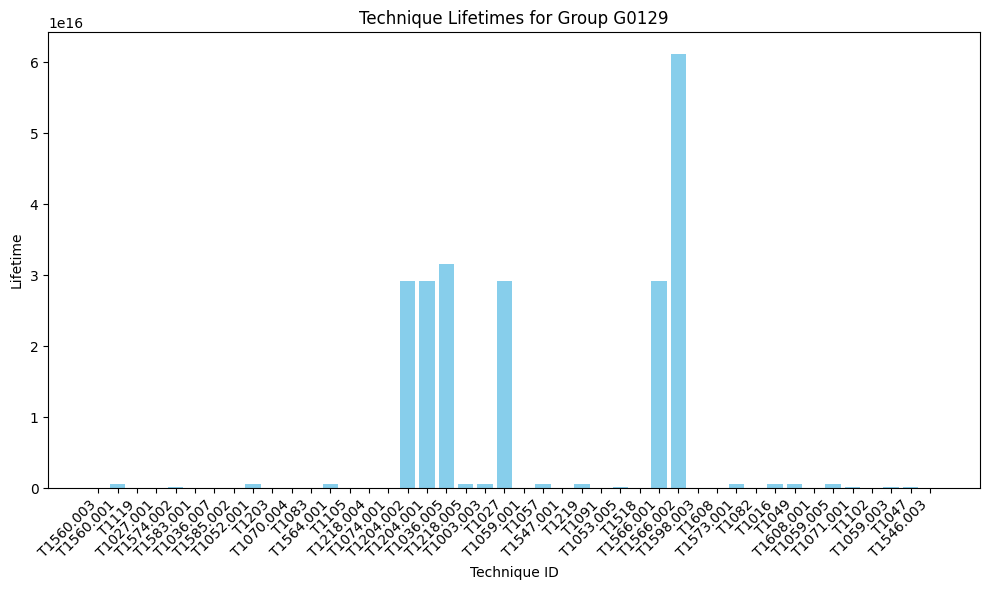

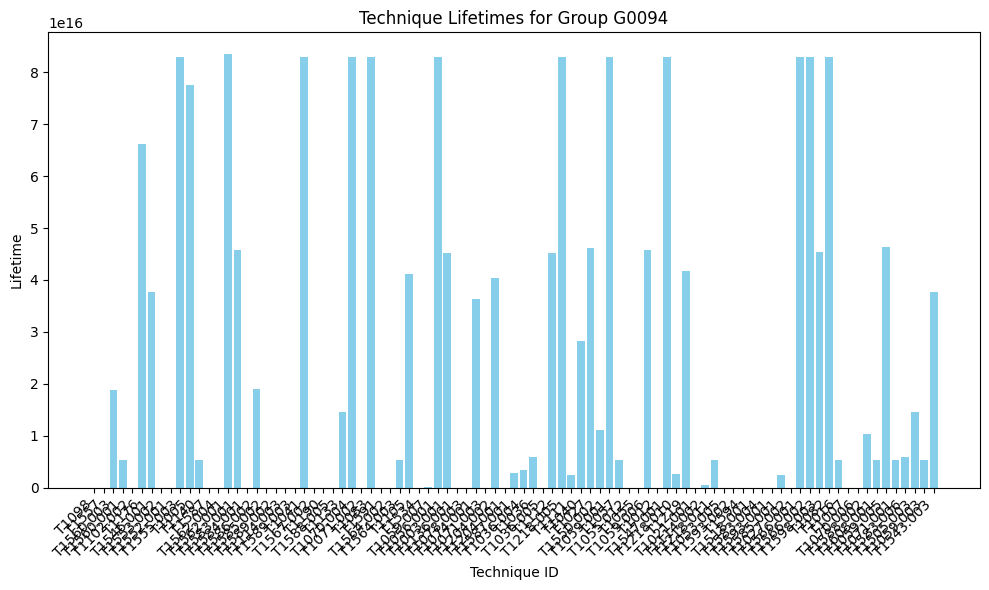

In [6]:
# Convert 'created' and 'last_modified' columns to datetime objects
df['created'] = pd.to_datetime(df['created'])
df['last modified'] = pd.to_datetime(df['last modified'])

# Calculate technique lifetime
df['lifetime'] = df['last modified'] - df['created']

# Iterate over the top 10 groups
for specific_group in top_10_groups['sourceID']:
    group_data = df[df['sourceID'] == specific_group]
    
    if not group_data.empty:
        # Initialize lists to store technique IDs and lifetimes
        technique_ids = []
        lifetimes = []
        
        # Iterate over unique targetIDs within the group
        for specific_technique in group_data['targetID'].unique():
            technique_data = group_data[group_data['targetID'] == specific_technique]
            lifetime = technique_data['lifetime'].values[0] if not technique_data.empty else None
            
            # Append technique ID and lifetime to lists
            technique_ids.append(specific_technique)
            lifetimes.append(lifetime)
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(technique_ids, lifetimes, color='skyblue')
        plt.title(f"Technique Lifetimes for Group {specific_group}")
        plt.xlabel('Technique ID')
        plt.ylabel('Lifetime')
        plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for the specified group {specific_group}.")

Top 10 techniques over time

In [7]:
df['created'] = pd.to_datetime(df['created'])

# Group by targetID and year, count unique sourceIDs
grouped_data = df.groupby(['targetID', pd.Grouper(key='created', freq='Y')])['sourceID'].nunique().reset_index(name='count')

# Find the top 10 targetIDs
top_10_targetIDs = grouped_data.groupby('targetID')['count'].sum().nlargest(10).index

print("Top 10 targetIDs over time:")
print(top_10_targetIDs)

# Create an empty list to store results
target_data_list = []

for targetID in top_10_targetIDs:
  # Filter data for the current targetID
  target_data = df[df['targetID'] == targetID]
  
  # Extract sourceIDs and years into separate lists
  source_ids = target_data['sourceID'].tolist()
  years = target_data['created'].dt.year.tolist()
  
  # Combine sourceIDs and years into a dictionary
  target_data_dict = {'targetID': targetID, 'sourceIDs': source_ids, 'years': years}
  
  # Append the dictionary to the results list
  target_data_list.append(target_data_dict)

# Print the results
for data in target_data_list:
  print(f"Target ID: {data['targetID']}")
  print(f"Source IDs: {data['sourceIDs']}")
  print(f"Years: {data['years']}")
  print("-" * 20)

Top 10 targetIDs over time:
Index(['T1204.002', 'T1105', 'T1566.001', 'T1059.001', 'T1588.002',
       'T1059.003', 'T1027', 'T1547.001', 'T1036.005', 'T1071.001'],
      dtype='object', name='targetID')
Target ID: T1204.002
Source IDs: ['G0099', 'G0005', 'G0073', 'G0007', 'G0016', 'G0013', 'G0050', 'G0064', 'G0067', 'G0082', 'G0087', 'G0130', 'G0138', 'G1007', 'G1002', 'G0060', 'G0098', 'G1012', 'G0080', 'G0142', 'G0070', 'G0079', 'G0012', 'G0035', 'G1011', 'G1006', 'G0066', 'G1003', 'G0085', 'G0037', 'G0046', 'G0061', 'G0137', 'G0084', 'G0047', 'G0078', 'G1001', 'G0126', 'G0100', 'G0136', 'G0119', 'G0094', 'G0032', 'G0140', 'G0065', 'G0095', 'G0059', 'G0103', 'G0021', 'G0069', 'G0129', 'G0019', 'G0133', 'G0049', 'G0068', 'G0056', 'G0040', 'G0048', 'G0075', 'G0034', 'G1008', 'G0121', 'G0091', 'G1018', 'G0062', 'G0092', 'G0127', 'G0089', 'G0027', 'G0131', 'G0134', 'G0081', 'G0090', 'G0107', 'G0112', 'G0102', 'G0018', 'G0045']
Years: [2020, 2019, 2018, 2018, 2018, 2020, 2018, 2020, 2018

C:\Users\manvi\AppData\Local\Temp\ipykernel_14596\1727385714.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  grouped_data = df.groupby(['targetID', pd.Grouper(key='created', freq='Y')])['sourceID'].nunique().reset_index(name='count')


C:\Users\manvi\AppData\Local\Temp\ipykernel_14596\1889785855.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10').colors  # Define colors for lines


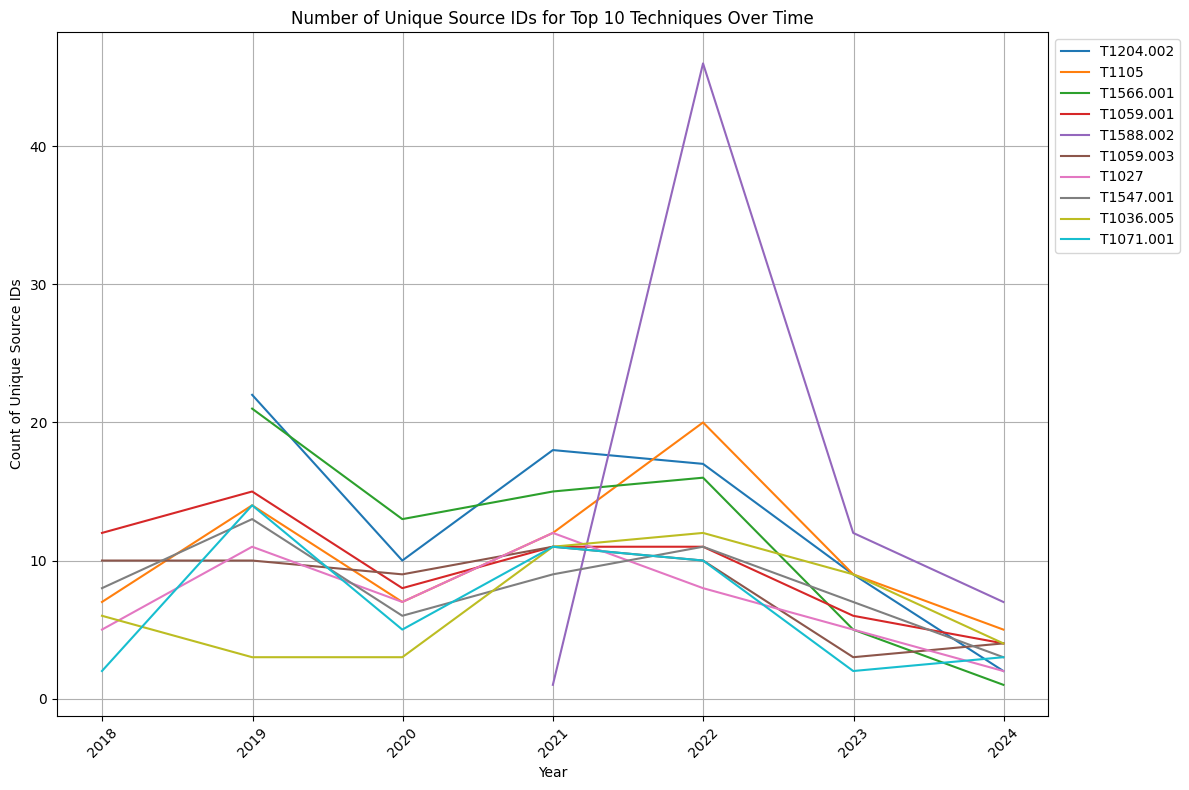

In [8]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.get_cmap('tab10').colors  # Define colors for lines

for i, targetID in enumerate(top_10_targetIDs):
  target_data = grouped_data[grouped_data['targetID'] == targetID]
  ax.plot(target_data['created'], target_data['count'], label=targetID, color=colors[i])

ax.set_title('Number of Unique Source IDs for Top 10 Techniques Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Count of Unique Source IDs')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Group by targetID and year, count unique sourceIDs
grouped_data = df.groupby(['targetID', pd.Grouper(key='created', freq='Y')])['sourceID'].nunique().reset_index(name='count')

# Sort grouped data by 'created' (year) in descending order
sorted_grouped_data = grouped_data.sort_values(by='created', ascending=False)

# Get the latest year present in the data
latest_year = sorted_grouped_data['created'].iloc[0].year  # Access the first year (latest)

# Filter data for the latest year
latest_year_data = sorted_grouped_data[sorted_grouped_data['created'].dt.year == latest_year]

# Find the top 10 targetIDs (by count) for the latest year
latest_top_10_targetIDs = latest_year_data.nlargest(10, 'count')['targetID'].tolist()

print("Top 10 Latest Techniques:")
print(top_10_targetIDs)

# Create an empty list to store results
target_data_list = []

for targetID in top_10_targetIDs:
  # Filter data for the current targetID
  target_data = df[df['targetID'] == targetID]
  
  # Extract sourceIDs and years into separate lists
  source_ids = target_data['sourceID'].tolist()
  years = target_data['created'].dt.year.tolist()
  
  # Combine sourceIDs and years into a dictionary
  target_data_dict = {'targetID': targetID, 'sourceIDs': source_ids, 'years': years}
  
  # Append the dictionary to the results list
  target_data_list.append(target_data_dict)

# Print the results
for data in target_data_list:
  print(f"Target ID: {data['targetID']}")
  print(f"Source IDs: {data['sourceIDs']}")
  print(f"Years: {data['years']}")
  print("-" * 20)

Top 10 Latest Techniques:
Index(['T1204.002', 'T1105', 'T1566.001', 'T1059.001', 'T1588.002',
       'T1059.003', 'T1027', 'T1547.001', 'T1036.005', 'T1071.001'],
      dtype='object', name='targetID')
Target ID: T1204.002
Source IDs: ['G0099', 'G0005', 'G0073', 'G0007', 'G0016', 'G0013', 'G0050', 'G0064', 'G0067', 'G0082', 'G0087', 'G0130', 'G0138', 'G1007', 'G1002', 'G0060', 'G0098', 'G1012', 'G0080', 'G0142', 'G0070', 'G0079', 'G0012', 'G0035', 'G1011', 'G1006', 'G0066', 'G1003', 'G0085', 'G0037', 'G0046', 'G0061', 'G0137', 'G0084', 'G0047', 'G0078', 'G1001', 'G0126', 'G0100', 'G0136', 'G0119', 'G0094', 'G0032', 'G0140', 'G0065', 'G0095', 'G0059', 'G0103', 'G0021', 'G0069', 'G0129', 'G0019', 'G0133', 'G0049', 'G0068', 'G0056', 'G0040', 'G0048', 'G0075', 'G0034', 'G1008', 'G0121', 'G0091', 'G1018', 'G0062', 'G0092', 'G0127', 'G0089', 'G0027', 'G0131', 'G0134', 'G0081', 'G0090', 'G0107', 'G0112', 'G0102', 'G0018', 'G0045']
Years: [2020, 2019, 2018, 2018, 2018, 2020, 2018, 2020, 2018, 

C:\Users\manvi\AppData\Local\Temp\ipykernel_14596\1147260826.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  grouped_data = df.groupby(['targetID', pd.Grouper(key='created', freq='Y')])['sourceID'].nunique().reset_index(name='count')


C:\Users\manvi\AppData\Local\Temp\ipykernel_14596\806992760.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10').colors  # Define colors for lines


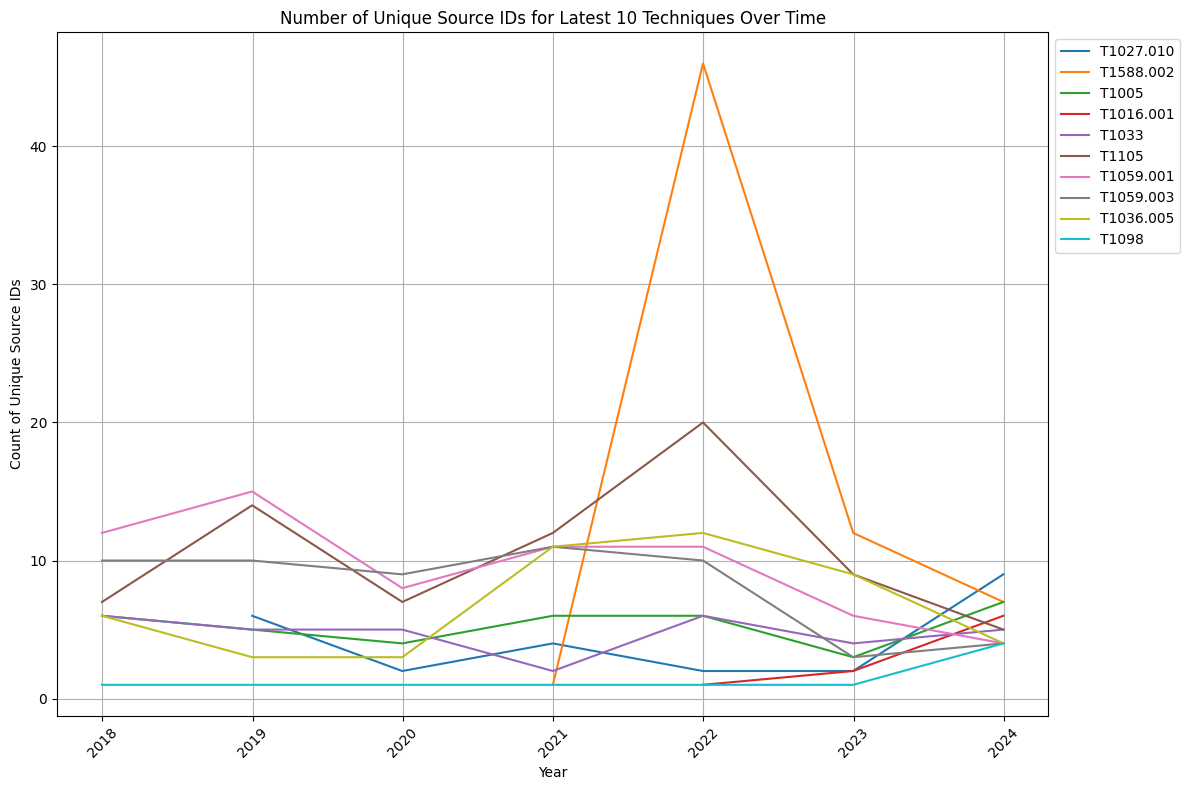

In [10]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.get_cmap('tab10').colors  # Define colors for lines

for i, targetID in enumerate(latest_top_10_targetIDs):
  target_data = grouped_data[grouped_data['targetID'] == targetID]
  ax.plot(target_data['created'], target_data['count'], label=targetID, color=colors[i])

ax.set_title('Number of Unique Source IDs for Latest 10 Techniques Over Time')
ax.set_xlabel('Year')
ax.set_ylabel('Count of Unique Source IDs')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Top Groups

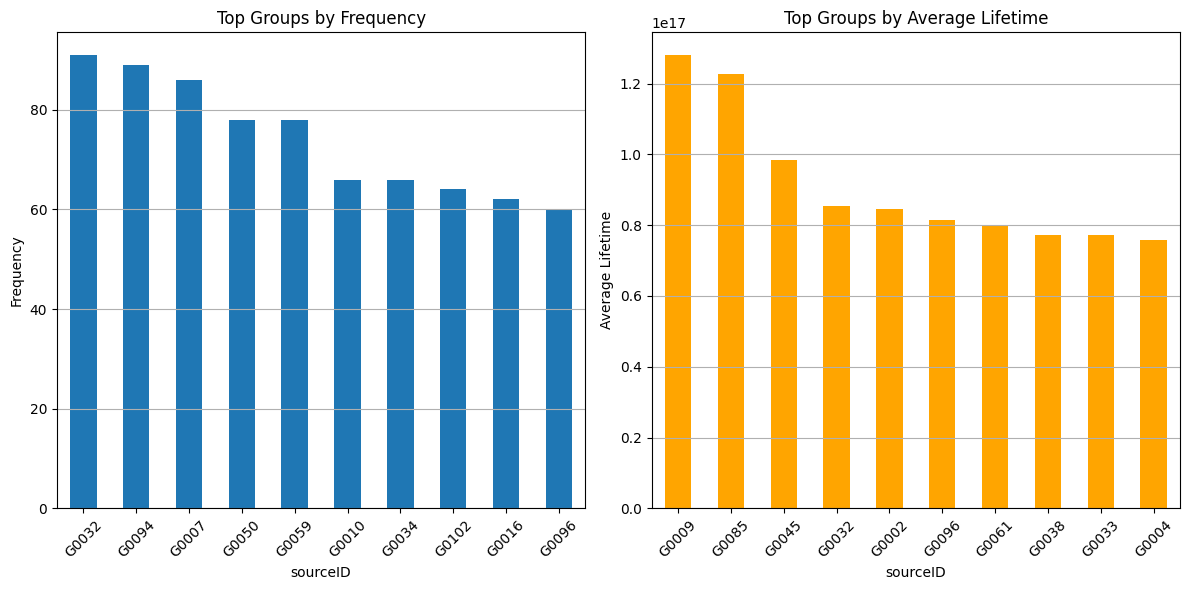

In [11]:
grouped_data = df.groupby('sourceID')
source_frequency = grouped_data.size()
source_avg_lifetime = grouped_data['lifetime'].mean()
top_groups_by_frequency = source_frequency.sort_values(ascending=False).head(10)
top_groups_by_avg_lifetime = source_avg_lifetime.sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))

# Plot the top groups by frequency
plt.subplot(1, 2, 1)
top_groups_by_frequency.plot(kind='bar')
plt.title('Top Groups by Frequency')
plt.xlabel('sourceID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Plot the top groups by average lifetime
plt.subplot(1, 2, 2)
top_groups_by_avg_lifetime.plot(kind='bar', color='orange')
plt.title('Top Groups by Average Lifetime')
plt.xlabel('sourceID')
plt.ylabel('Average Lifetime')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

In [13]:
!pip install statsmodels

  Using cached statsmodels-0.14.1-cp312-cp312-win_amd64.whl.metadata (9.8 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
Using cached statsmodels-0.14.1-cp312-cp312-win_amd64.whl (9.8 MB)
Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)


c:\Users\manvi\.virtualenvs\ttps-co-occurrence-main-Jm0XMtft\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\manvi\.virtualenvs\ttps-co-occurrence-main-Jm0XMtft\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\manvi\.virtualenvs\ttps-co-occurrence-main-Jm0XMtft\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\manvi\.virtualenvs\ttps-co-occurrence-main-Jm0XMtft\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: N

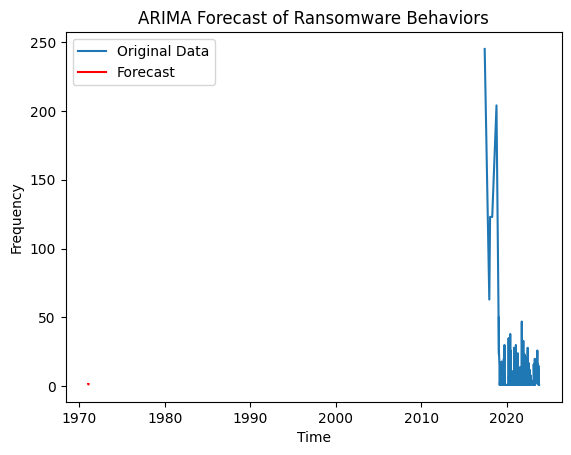

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  385
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1569.998
Date:                Thu, 21 Mar 2024   AIC                           3145.997
Time:                        00:37:49   BIC                           3157.849
Sample:                             0   HQIC                          3150.698
                                - 385                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2605      0.027     -9.648      0.000      -0.313      -0.208
ma.L1         -0.4417      0.031    -14.095      0.000      -0.503      -0.380
sigma2       208.0946      3.980     52.283      0.0

In [14]:
from statsmodels.tsa.arima.model import ARIMA

time_series = df.groupby('created').size()

# Fit ARIMA model
# For simplicity, we'll use a basic ARIMA(1,1,1) model
arima_model = ARIMA(time_series, order=(1,1,1))
arima_result = arima_model.fit()

# Forecast future values
forecast_steps = 10  # Adjust as needed
forecast = arima_result.forecast(steps=forecast_steps)

# Plot the original data and forecast
plt.plot(time_series, label='Original Data')
plt.plot(range(len(time_series), len(time_series) + forecast_steps), forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast of Ransomware Behaviors')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print the ARIMA model summary
print(arima_result.summary())

c:\Users\manvi\.virtualenvs\ttps-co-occurrence-main-Jm0XMtft\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\manvi\.virtualenvs\ttps-co-occurrence-main-Jm0XMtft\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\manvi\.virtualenvs\ttps-co-occurrence-main-Jm0XMtft\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


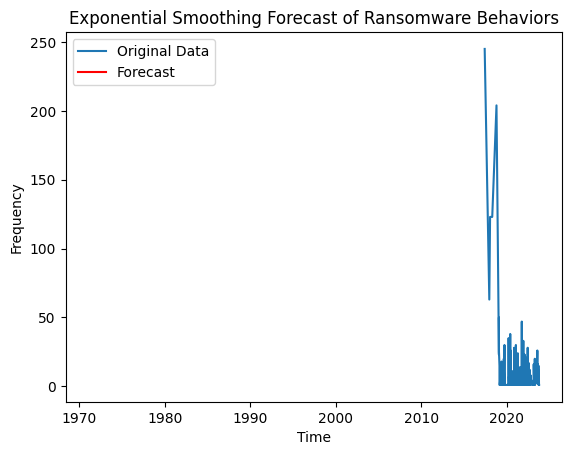

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                   None   No. Observations:                  385
Model:             SimpleExpSmoothing   SSE                          89886.772
Optimized:                       True   AIC                           2103.429
Trend:                           None   BIC                           2111.336
Seasonal:                        None   AICC                          2103.534
Seasonal Periods:                None   Date:                 Thu, 21 Mar 2024
Box-Cox:                        False   Time:                         00:37:56
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.5566652                alpha                 True
initial_level              245.00000                

In [15]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Fit Simple Exponential Smoothing model
ses_model = SimpleExpSmoothing(time_series)
ses_result = ses_model.fit()

# Forecast future values
forecast_steps = 10  # Adjust as needed
forecast = ses_result.forecast(steps=forecast_steps)

# Plot the original data and forecast
plt.plot(time_series, label='Original Data')
plt.plot(range(len(time_series), len(time_series) + forecast_steps), forecast, label='Forecast', color='red')
plt.title('Exponential Smoothing Forecast of Ransomware Behaviors')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Print the Simple Exponential Smoothing model summary
print(ses_result.summary())